In [1]:
import sys
import os

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from few.trajectory.inspiral import EMRIInspiral
from few.amplitude.romannet import RomanAmplitude
from few.amplitude.interp2dcubicspline import Interp2DAmplitude
from few.waveform import FastSchwarzschildEccentricFlux, SlowSchwarzschildEccentricFlux, GenerateEMRIWaveform
from few.utils.utility import (get_overlap, 
                               get_mismatch, 
                               get_fundamental_frequencies, 
                               get_separatrix, 
                               get_mu_at_t, 
                               get_p_at_t, 
                               get_kerr_geo_constants_of_motion,
                               xI_to_Y,
                               Y_to_xI)

from few.utils.ylm import GetYlms
from few.utils.modeselector import ModeSelector
from few.summation.interpolatedmodesum import CubicSplineInterpolant
from few.waveform import SchwarzschildEccentricWaveformBase
from few.summation.interpolatedmodesum import InterpolatedModeSum
from few.summation.directmodesum import DirectModeSum
from few.utils.constants import *
from few.summation.aakwave import AAKSummation
from few.waveform import Pn5AAKWaveform, AAKWaveformBase

In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# from lisatools.diagnostic import *
# from lisatools.sensitivity import get_sensitivity

from few.waveform import GenerateEMRIWaveform
from few.utils.constants import *
from few.utils.utility import *
from few.trajectory.inspiral import EMRIInspiral
traj_module = EMRIInspiral(func="SchwarzEccFlux")

from scipy.signal.windows import tukey, hann, boxcar, nuttall, blackman
from few.utils.fdutils import *

import warnings
warnings.filterwarnings("ignore")


In [28]:
def power_spectral_density_RCLfit(freq):
    r"""
    Return the effective power spectral density (PSD) of the detector noise
    at a given frequency, according to the analytical fit by Robson, Cornish
    and Liu, :arxiv:`1803.01944`

    INPUT:

    - ``freq`` -- frequency `f` (in `\mathrm{Hz}`)

    OUTPUT:

    - effective power spectral density `S(f)` (in `\mathrm{Hz}^{-1}`)

    EXAMPLES::

        sage: from kerrgeodesic_gw import lisa_detector
        sage: Sn = lisa_detector.power_spectral_density_RCLfit
        sage: Sn(1.e-1)  # tol 1.0e-13
        2.12858262120861e-39
        sage: Sn(1.e-2)  # tol 1.0e-13
        1.44307343517977e-40
        sage: Sn(1.e-3)  # tol 1.0e-13
        1.63410027259543e-38

    """
    p_oms = 2.25e-22 * (1 + (2.e-3/freq)**4)
    p_acc = 9.e-30 * (1 +(4.e-4/freq)**2) * (1 + (freq/8.e-3)**4)
    L = 2.5e9
    f_star = 1.909e-2
    p_n = (p_oms + 2*(1 + np.cos(freq/f_star)**2)*p_acc/(2*(np.pi)*freq)**4)/L**2
    return 10./3.*p_n*(1 + 0.6*(freq/f_star)**2)

In [3]:

# # frequency domain
# few_gen = GenerateEMRIWaveform(
#     "FastSchwarzschildEccentricFlux", use_gpu=True,
#     sum_kwargs=dict(pad_output=True, output_type="fd", odd_len=True),
#     return_list=True
# )

# time domain
td_gen = GenerateEMRIWaveform(
    "FastSchwarzschildEccentricFlux", use_gpu=True, 
    sum_kwargs=dict(pad_output=True, odd_len=True),
    return_list=True
)

In [4]:
# define the injection parameters
M = 4.15e6 # central object mass
a = 0.998  # will be ignored in Schwarzschild waveform
mu = 5e-2 # secondary object mass
p0 = 1.614 # initial semi-latus rectum
e0 = 0.5 # eccentricity
Phi_r0=0
x0 = 1.0  # will be ignored in Schwarzschild waveform
qK =  0 # polar spin angle
phiK = 0  # azimuthal viewing angle
qS = np.pi/3 # polar sky angle
phiS = 0  # azimuthal viewing angle
dist = 1.0  # distance
# initial phases
Phi_phi0 = 0.0
Phi_theta0 = np.pi/2

Tobs = 1.0 # observation time, if the inspiral is shorter, the it will be zero padded 
dt = 10.0 # time interval
eps = 1e-2 # mode content percentage
mode_selection = [(2,2,0)]

waveform_kwargs = {
    "T": Tobs,
    "dt": dt,
# you can uncomment the following lines if you want to show a specific mode or modes
#     "mode_selection" : mode_selection,
#     "include_minus_m": True
    "eps": eps,
    
}

# get the initial p0 
p0 = get_p_at_t(
    traj_module,
    Tobs*0.99,
    [M, mu, 0.0, e0, 1.0],
    index_of_p=3,
    index_of_a=2,
    index_of_e=4,
    index_of_x=5,
    traj_kwargs={},
    xtol=2e-12,
    rtol=8.881784197001252e-16,
    bounds=None,
)


emri_injection_params = [
    M,  
    mu,
    a, 
    p0, 
    e0, 
    x0,
    dist, 
    qS,
    phiS,
    qK, 
    phiK, 
    Phi_phi0, 
    Phi_theta0, 
    Phi_r0
]

In [5]:
data_channels_td = td_gen(*emri_injection_params, **waveform_kwargs)


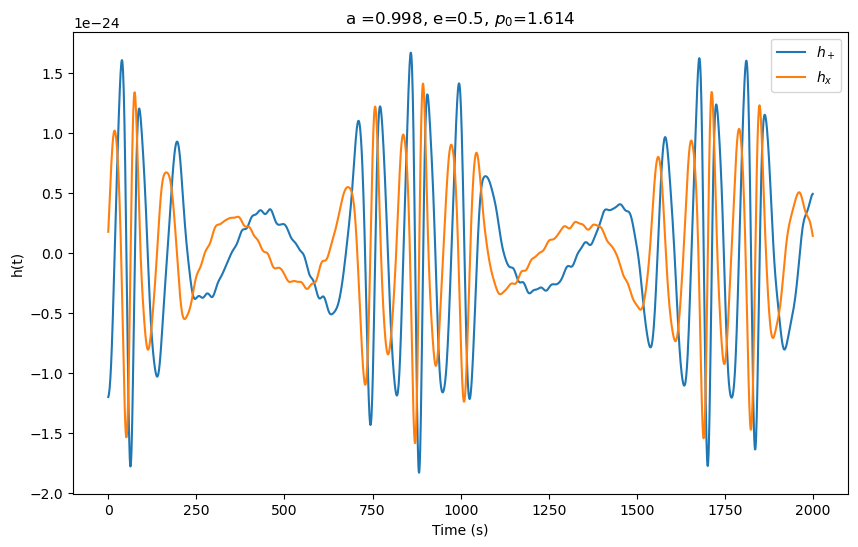

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(data_channels_td[0][:2000].get(), label=r"$h_+$")
plt.plot(data_channels_td[1][:2000].get(), label=r"$h_x$")
# plt.plot(data_channels_td[1].get(), label="h_cross")
plt.xlabel("Time (s)")
plt.ylabel("h(t)")
plt.title(f"a =0.998, e=0.5, $p_0$=1.614")
plt.legend()
plt.show()


In [7]:
type(  data_channels_td)

list

In [29]:
def data_set(mu, p0, e, intg_timem, a0):
    T = intg_timem 





# define the injection parameters
    M = 4.15e6 # central object mass
    a = 0.998  # will be ignored in Schwarzschild waveform
    mu = 5e-2 # secondary object mass
    # p0 = 1.614 # initial semi-latus rectum
    e0 = 0.5 # eccentricity
    Phi_r0=0
    x0 = 1.0  # will be ignored in Schwarzschild waveform
    qK =  0 # polar spin angle
    phiK = 0  # azimuthal viewing angle
    qS = np.pi/3 # polar sky angle
    phiS = 0  # azimuthal viewing angle
    dist = 1.0  # distance
    # initial phases
    Phi_phi0 = 0.0
    Phi_theta0 = np.pi/2
    
    Tobs = intg_timem # observation time, if the inspiral is shorter, the it will be zero padded 
    dt = 10.0 # time interval
    eps = 1e-2 # mode content percentage
    a = a0
    mu = mu
    p0 = p0
    e0 = e 
    x0 = 1.0
    qK = np.pi / 2
    phiK = 0.0
    qS = np.pi / 2
    phiS = 0.0
    dist = 0.000008277 
    Phi_phi0 = 0.0
    Phi_theta0 = 0.0
    Phi_r0 = 0.0
    mode_selection = [(2,2,0)]
    
    waveform_kwargs = {
        "T": Tobs,
        "dt": dt,
    # you can uncomment the following lines if you want to show a specific mode or modes
    #     "mode_selection" : mode_selection,
    #     "include_minus_m": True
        "eps": eps,
        
    }
    
    # get the initial p0 
    p0 = get_p_at_t(
        traj_module,
        Tobs*0.99,
        [M, mu, 0.0, e0, 1.0],
        index_of_p=3,
        index_of_a=2,
        index_of_e=4,
        index_of_x=5,
        traj_kwargs={},
        xtol=2e-12,
        rtol=8.881784197001252e-16,
        bounds=None,
    )
    
    
    emri_injection_params = [
        M,  
        mu,
        a, 
        p0, 
        e0, 
        x0,
        dist, 
        qS,
        phiS,
        qK, 
        phiK, 
        Phi_phi0, 
        Phi_theta0, 
        Phi_r0
    ]
    
        
    # h=np.array([])
    gA = td_gen(*emri_injection_params, **waveform_kwargs)
    # print(h)

    h1 =gA[0]
    h2= gA[1]
    h_real = np.array(h1.get())
    h_imag = np.array(h2.get())



    fft_TD = np.fft.fftshift(np.fft.fft(h_real)) * dt
    fft_TDX = np.fft.fftshift(np.fft.fft(h_imag)) * dt
    freq = np.fft.fftshift(np.fft.fftfreq(len(h_real), dt))
    positive_frequency_mask = (freq >= 0.0)
    a1 = freq[positive_frequency_mask]
    b1 = np.abs(fft_TD[positive_frequency_mask]) ** 2
    b2 = np.abs(fft_TDX[positive_frequency_mask]) ** 2
    pluspart = np.abs(fft_TD)**2
    crosspart = np.abs(fft_TDX)**2
    df = freq[1] - freq[0]
    integralp = np.zeros(len(pluspart))
    numerator = pluspart + crosspart
    denominator = power_spectral_density_RCLfit(freq)
    
    for i in range(len(numerator)):
        integralp[i] = numerator[i] / denominator[i]
    
    snr = np.sqrt((4 * np.sum(integralp) * df))




    return a0, e, p0, a1, b1, b2 , h_real, h_imag, freq, fft_TD, fft_TDX, snr


In [35]:
# 
# empty np array
emS=np.array([])
emS2=np.array([])
for e0 in np.linspace(0.5, 0.51, 5):
    for p0 in np.linspace(5, 10, 5):
        r1 = data_set(5e-2, p0, e0, 15/365,0.998)
        r2 = data_set(5e-2, p0, e0, 15/365,0.01)
        emS = np.append(emS, [r1[0],r1[1],r1[2],r1[-1]])
        emS2 = np.append(emS2, [r2[0],r2[1],r2[2],r2[-1]])

ValueError: This p0 (7.105299570422816) and e0 (0.5025) combination is outside of our domain of validity.